In [21]:
import pandas as pd
import numpy as np
import re
import requests
import datetime
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ambiance

In [22]:
def read_xls(file, sheet):
    
    try:
        df = pd.read_excel(file,sheet)
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [23]:
def read_csv(file):
    
    try:
        df = pd.read_csv(file, sep=' ')
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [24]:
def calculate_bearing(d):
  dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
  ix = int(round(d / (360. / len(dirs))))
    
  return dirs[ix % len(dirs)]

In [25]:
def convert_lat_gps_coord(coor):
    
    lat_deg = coor[:2]
    lat_min = coor[2:4]
    lat_sec = coor[5:7]
    direction = coor[7]
    
    dd = (float(lat_deg) + float(lat_min)/60 + float(lat_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

    return dd

In [26]:
def convert_lon_gps_coord(coor):
    
    lon_deg = coor[1:3]
    lon_min = coor[3:5]
    lon_sec = coor[6:8]
    direction = coor[8]
    
    dd = (float(lon_deg) + float(lon_min)/60 + float(lon_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
    
    return dd

In [27]:
def plot(lat, lng, zoom=10, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    p = gmap(api_key, gmap_options, title='Pays de Gex', 
             width=bokeh_width, height=bokeh_height)
    # definition of the column data source: 
    source = ColumnDataSource(df)
    # see how we specify the x and y columns as strings, 
    # and how to declare as a source the ColumnDataSource:
    center = p.circle('lon', 'lat', size=4, alpha=0.2, 
                      color='yellow', source=source)
    show(p)
    return p

In [28]:
def Alt_toPressure(val):

    return ambiance.Atmosphere(val).pressure[0]

In [29]:
def Alt_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere(val).temperature)[0]

In [30]:
def Alt_toLayerName(val):
    
    return ambiance.Atmosphere(val).layer_name[0]

In [31]:
def Pressure_toAlt(val):

    return ambiance.Atmosphere.from_pressure(val).h[0]

In [32]:
def Pressure_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere.from_pressure(val).temperature)[0]

In [33]:
def Clean_Pressure(val):

    # Remove bad data
    if val > 200000:
        return val/100
    return val

### Read Input Telemetry Spreadsheet

In [34]:
df = read_xls("KB9LNS-13.xlsx","KB9LNS-13")

In [35]:
df.sample(10)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,Num,Column15
39,2023-04-21,10:41:08,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/154104h4...",086TxC,7.50C,2280.85hPa,6.12V,07S,Atlas,5,NaN
44,2023-04-21,10:52:07,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,K9MQ-1:/155203h41...",091TxC,9.60C,2322.88hPa,6.12V,07S,Atlas,5,NaN
3,2023-04-21,09:32:35,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143230h40...",052TxC,25.20C,712.48hPa,6.27V,05S,Atlas,5,NaN
47,2023-04-21,11:01:08,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,AA8HS-1:/160104h4...",094TxC,11.80C,2370.80hPa,6.09V,07S,Atlas,5,NaN
17,2023-04-21,09:55:48,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,K9NDU-2:/145543h4...",066TxC,14.90C,149.16hPa,6.24V,06S,Atlas,5,NaN
35,2023-04-21,10:32:25,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,K9MQ-1:/153221h41...",083TxC,6.20C,2244.45hPa,6.14V,06S,Atlas,5,NaN
12,2023-04-21,09:49:11,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/144907h4...",061TxC,18.40C,281.15hPa,6.25V,04S,Atlas,5,NaN
32,2023-04-21,10:26:14,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/152610h41...",080TxC,6.70C,2268.99hPa,6.10V,07S,Atlas,5,NaN
19,2023-04-21,10:00:08,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/150004h4...",068TxC,13.90C,100.68hPa,6.17V,07S,Atlas,5,NaN
36,2023-04-21,10:33:32,CDT:,"KB9LNS-13>APLIGA,JAMTWP,WIDE2*,qAR,HOLLY:/1531...",082TxC,6.50C,2253.40hPa,6.14V,07S,Atlas,5,NaN


In [36]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'TxC', 'Interior Temp ©', 'Pressure',
       'Battery', 'Sat', 'Name', 'Num', 'Column15'],
      dtype='object')

In [37]:
# View large sample of df
df.head(15)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,Num,Column15
0,2023-04-21,09:26:05,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/142600h4...",049TxC,26.30C,956.16hPa,6.19V,05S,Atlas,5,!wVb!
1,2023-04-21,09:30:28,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143023h40...",050TxC,26.70C,802.26hPa,6.20V,06S,Atlas,5,!w4S!
2,2023-04-21,09:31:31,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/143126...",051TxC,25.90C,754.47hPa,6.25V,05S,Atlas,5,!wWv!
3,2023-04-21,09:32:35,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143230h40...",052TxC,25.20C,712.48hPa,6.27V,05S,Atlas,5,NaN
4,2023-04-21,09:36:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/143555h4...",053TxC,25.00C,622.88hPa,6.20V,05S,Atlas,5,NaN
5,2023-04-21,09:38:59,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143855h40...",054TxC,24.50C,546.95hPa,6.20V,05S,Atlas,5,NaN
6,2023-04-21,09:40:03,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/143958h4...",055TxC,23.70C,503.49hPa,6.25V,05S,Atlas,5,NaN
7,2023-04-21,09:41:09,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/144104...",056TxC,22.70C,465.29hPa,6.25V,05S,Atlas,5,NaN
8,2023-04-21,09:42:10,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:/144206h...",057TxC,22.00C,435.95hPa,6.27V,05S,Atlas,5,NaN
9,2023-04-21,09:46:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KA3BQE:/144555h40...",058TxC,20.70C,367.51hPa,6.19V,05S,Atlas,5,NaN


### Prepare Telemetry Tracker Data

In [38]:
# Flight telemetry info
df.head(15)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,Num,Column15
0,2023-04-21,09:26:05,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/142600h4...",049TxC,26.30C,956.16hPa,6.19V,05S,Atlas,5,!wVb!
1,2023-04-21,09:30:28,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143023h40...",050TxC,26.70C,802.26hPa,6.20V,06S,Atlas,5,!w4S!
2,2023-04-21,09:31:31,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/143126...",051TxC,25.90C,754.47hPa,6.25V,05S,Atlas,5,!wWv!
3,2023-04-21,09:32:35,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143230h40...",052TxC,25.20C,712.48hPa,6.27V,05S,Atlas,5,NaN
4,2023-04-21,09:36:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/143555h4...",053TxC,25.00C,622.88hPa,6.20V,05S,Atlas,5,NaN
5,2023-04-21,09:38:59,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143855h40...",054TxC,24.50C,546.95hPa,6.20V,05S,Atlas,5,NaN
6,2023-04-21,09:40:03,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/143958h4...",055TxC,23.70C,503.49hPa,6.25V,05S,Atlas,5,NaN
7,2023-04-21,09:41:09,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/144104...",056TxC,22.70C,465.29hPa,6.25V,05S,Atlas,5,NaN
8,2023-04-21,09:42:10,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:/144206h...",057TxC,22.00C,435.95hPa,6.27V,05S,Atlas,5,NaN
9,2023-04-21,09:46:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KA3BQE:/144555h40...",058TxC,20.70C,367.51hPa,6.19V,05S,Atlas,5,NaN


In [39]:
# Expand Telemetry data into all fields

# APRS Telemetry field
df['Telemetry'] = df['Path'].str.split(':', expand=True)[1]
df['Path']      = df['Path'].str.split(':', expand=True)[0]

# GPS Time and Location
df['GPS Time']      = df['Telemetry'].str.split('/', expand=True)[1].str.split('h', expand=True)[0]
df['Lat']           = df['Telemetry'].str.split('/', expand=True)[1].str.split('h', expand=True)[1]
df['Lon']           = df['Telemetry'].str.split('/', expand=True)[2].str.split('W', expand=True)[0] + 'W'
df['Bearing']       = df['Telemetry'].str.split('/', expand=True)[2].str.split('W', expand=True)[1]
df['Speed (mph)']   = df['Telemetry'].str.split('/', expand=True)[3].astype(float)
df['Altitude (ft)'] = df['Telemetry'].str.split('/', expand=True)[4].str.split('=', expand=True)[1].astype(float)

# Tracker Status field
df['Voltage']       = df['Battery'].str.split('V', expand=True)[0]
df['Sat']           = df['Sat'].str.split('S', expand=True)[0]

In [40]:
# Unit Conversions

# Time
df['Time'] = pd.to_datetime(df['GPS Time'].str[:6],format= '%H%M%S' ).dt.time

# Speed and distance
df['Speed (kph)']  = df['Speed (mph)'].astype(float) * 1.609344
df['Altitude (m)'] = df['Altitude (ft)'].astype(float) * 0.3048

# Tempuratures
df['Interior Temp (F)'] = df['Interior Temp ©'].str.split('C', expand=True)[0].astype(float)*(9/5)+32
#df2['Exterior Temp (F)'] = df2['Exterior Temp ©'].str.split('C', expand=True)[0].astype(float)*(9/5)+32

# Pressure
df['I Pressure'] = df['Pressure'].str[:4].astype(float)
df['I Pressure'] = pd.Series(df['I Pressure']*100).apply(Clean_Pressure).ffill()
#df2['E Pressure'] = df2['Exterior Pressure'].str[:4].astype(float)

In [41]:
# Compute new telemetry data fields

# Ascent Rate (ft)
df['Altitude Delta (ft)'] = df['Altitude (ft)'].diff()
df['Time Delta (s)'] = pd.to_timedelta(df['Time'].astype(str)).diff(-1).dt.total_seconds().abs()
df['Rate (fps)'] = df['Altitude Delta (ft)'].astype(float) / df['Time Delta (s)'].astype(float)

# Ascent Rate (m)
df['Altitude Delta (m)'] = df['Altitude (m)'].diff()
df['Rate (mps)'] = df['Altitude Delta (m)'].astype(float) / df['Time Delta (s)'].astype(float)

# Direction
df['Cardinal Direction'] = df['Bearing'].str[1:].astype(float).apply(calculate_bearing)

# Time
df['GPS Epoch'] = pd.to_timedelta(df['Time'].astype(str)).dt.total_seconds().astype(int)
epoch=df['GPS Epoch'].iloc[0]
df['GPS Epoch'] = df['GPS Epoch'] - epoch

#### Atmospheric Predictions

In [42]:
# Atmospheric predictions using ISA reference data

# Altitude based predictions
df['Predict Alt Pressure'] = df['Altitude (m)'].apply(Alt_toPressure)
df['Predict Alt Temp(C)'] = df['Altitude (m)'].apply(Alt_toTemp)
df['Predict Alt Temp(F)'] = df['Predict Alt Temp(C)'].astype(float)*(9/5)+32

# Pressure based predictions
df['Predict IP Alt(m)'] = pd.Series(df['I Pressure']).apply(Pressure_toAlt)
df['Predict IP Alt(ft)'] = pd.Series(df['I Pressure']).apply(Pressure_toAlt) * 3.2808399
df['Predict IP Temp(C)'] = pd.Series(df['I Pressure']).apply(Pressure_toTemp)
df['Predict IP Temp(F)'] = df['Predict IP Temp(C)']*(9/5)+32

# Pressure based predictions
#df2['Predict EP Alt(m)'] = pd.Series(df2['E Pressure']*100).apply(Pressure_toAlt)
#df2['Predict EP Alt(ft)'] = df2['Predict EP Alt(m)'] * 3.2808399
#df2['Predict EP Temp(C)'] = pd.Series(df2['E Pressure']*100).apply(Pressure_toTemp)
#df2['Predict EP Temp(F)'] = df2['Predict EP Temp(C)']*(9/5)+32

In [43]:
df.iloc[30]

Date                                            2023-04-21 00:00:00
Time                                                       15:22:20
TZ                                                             CDT:
Path                            KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1
TxC                                                          079TxC
Interior Temp ©                                               6.20C
Pressure                                                 2244.63hPa
Battery                                                       6.17V
Sat                                                              07
Name                                                          Atlas
Num                                                               5
Column15                                                        NaN
Telemetry               /152220h4113.69N/08811.63WO081/014/A=065636
GPS Time                                                     152220
Lat                                             

In [44]:
# Convert pressure from Pa to hPa
df['I Pressure'] = df['I Pressure']/100
df['Predict Alt Pressure'] = df['Predict Alt Pressure']/100

### Read International Standard Atmosphere Tables

In [45]:
isa = read_csv("International Standard Atmosphere Table.txt")

In [46]:
isa.head(10)

,(ft),(m),𝜽,(K),(◦C),𝜹,(N/m2),(lb/ft2),𝝈,(kg/m3),(slug/ft3),(m/s),(ft/s),(kt)
0,−2000,−609.6,1.0138,292.11,18.96,1.0744,108866,2273.7,1.0598,1.2983,0.002519,342.6,1124.0,666.0
1,−1800,−548.6,1.0124,291.72,18.57,1.0668,108092,2257.5,1.0537,1.2908,0.002505,342.4,1123.0,665.6
2,−1600,−487.7,1.0110,291.32,18.17,1.0592,107322,2241.5,1.0477,1.2834,0.002490,342.2,1123.0,665.1
3,−1400,−426.7,1.0096,290.92,17.77,1.0516,106557,2225.5,1.0416,1.2760,0.002476,341.9,1122.0,664.7
4,−1200,−365.8,1.0083,290.53,17.38,1.0441,105797,2209.6,1.0356,1.2686,0.002461,341.7,1121.0,664.2
5,−1000,−304.8,1.0069,290.13,16.98,1.0367,105041,2193.8,1.0296,1.2612,0.002447,341.5,1120.0,663.7
6,−800,−243.8,1.0055,289.73,16.58,1.0293,104289,2178.1,1.0236,1.2539,0.002433,341.2,1120.0,663.3
7,−600,−182.9,1.0041,289.34,16.19,1.0219,103541,2162.5,1.0177,1.2467,0.002419,341.0,1119.0,662.8
8,−400,−121.9,1.0028,288.94,15.79,1.0145,102798,2147.0,1.0118,1.2394,0.002405,340.8,1118.0,662.4
9,−200,−61.0,1.0014,288.55,15.40,1.0072,102059,2131.6,1.0059,1.2322,0.002391,340.5,1117.0,661.9


In [47]:
isa['hpa'] = isa['(N/m2)']/100

In [48]:
isa['(F)'] = (isa['(◦C)'].str.strip(' ').str.replace('−','-').astype(float)*(9/5))+32

In [49]:
isa.sample(5)

,(ft),(m),𝜽,(K),(◦C),𝜹,(N/m2),(lb/ft2),𝝈,(kg/m3),(slug/ft3),(m/s),(ft/s),(kt),hpa,(F)
35,5000,1524.0,0.9656,278.24,5.09,0.8320,84307,1760.8,0.8617,1.0555,0.002048,334.4,1097.0,650.0,843.07,41.162
80,14000,4267.2,0.9037,260.41,−12.74,0.5875,59524,1243.2,0.6500,0.7963,0.001545,323.5,1061.0,628.8,595.24,9.068
139,25800,7863.8,0.8226,237.04,−36.11,0.3583,36307,758.3,0.4356,0.5336,0.001035,308.6,1013.0,599.9,363.07,-32.998
96,17200,5242.6,0.8817,254.07,−19.08,0.5161,52292,1092.1,0.5853,0.7170,0.001391,319.5,1048.0,621.1,522.92,-2.344
302,58400,17800.3,0.7519,216.65,−56.50,0.0764,7745,161.8,0.1017,0.1245,0.000242,295.1,968.1,573.6,77.45,-69.700


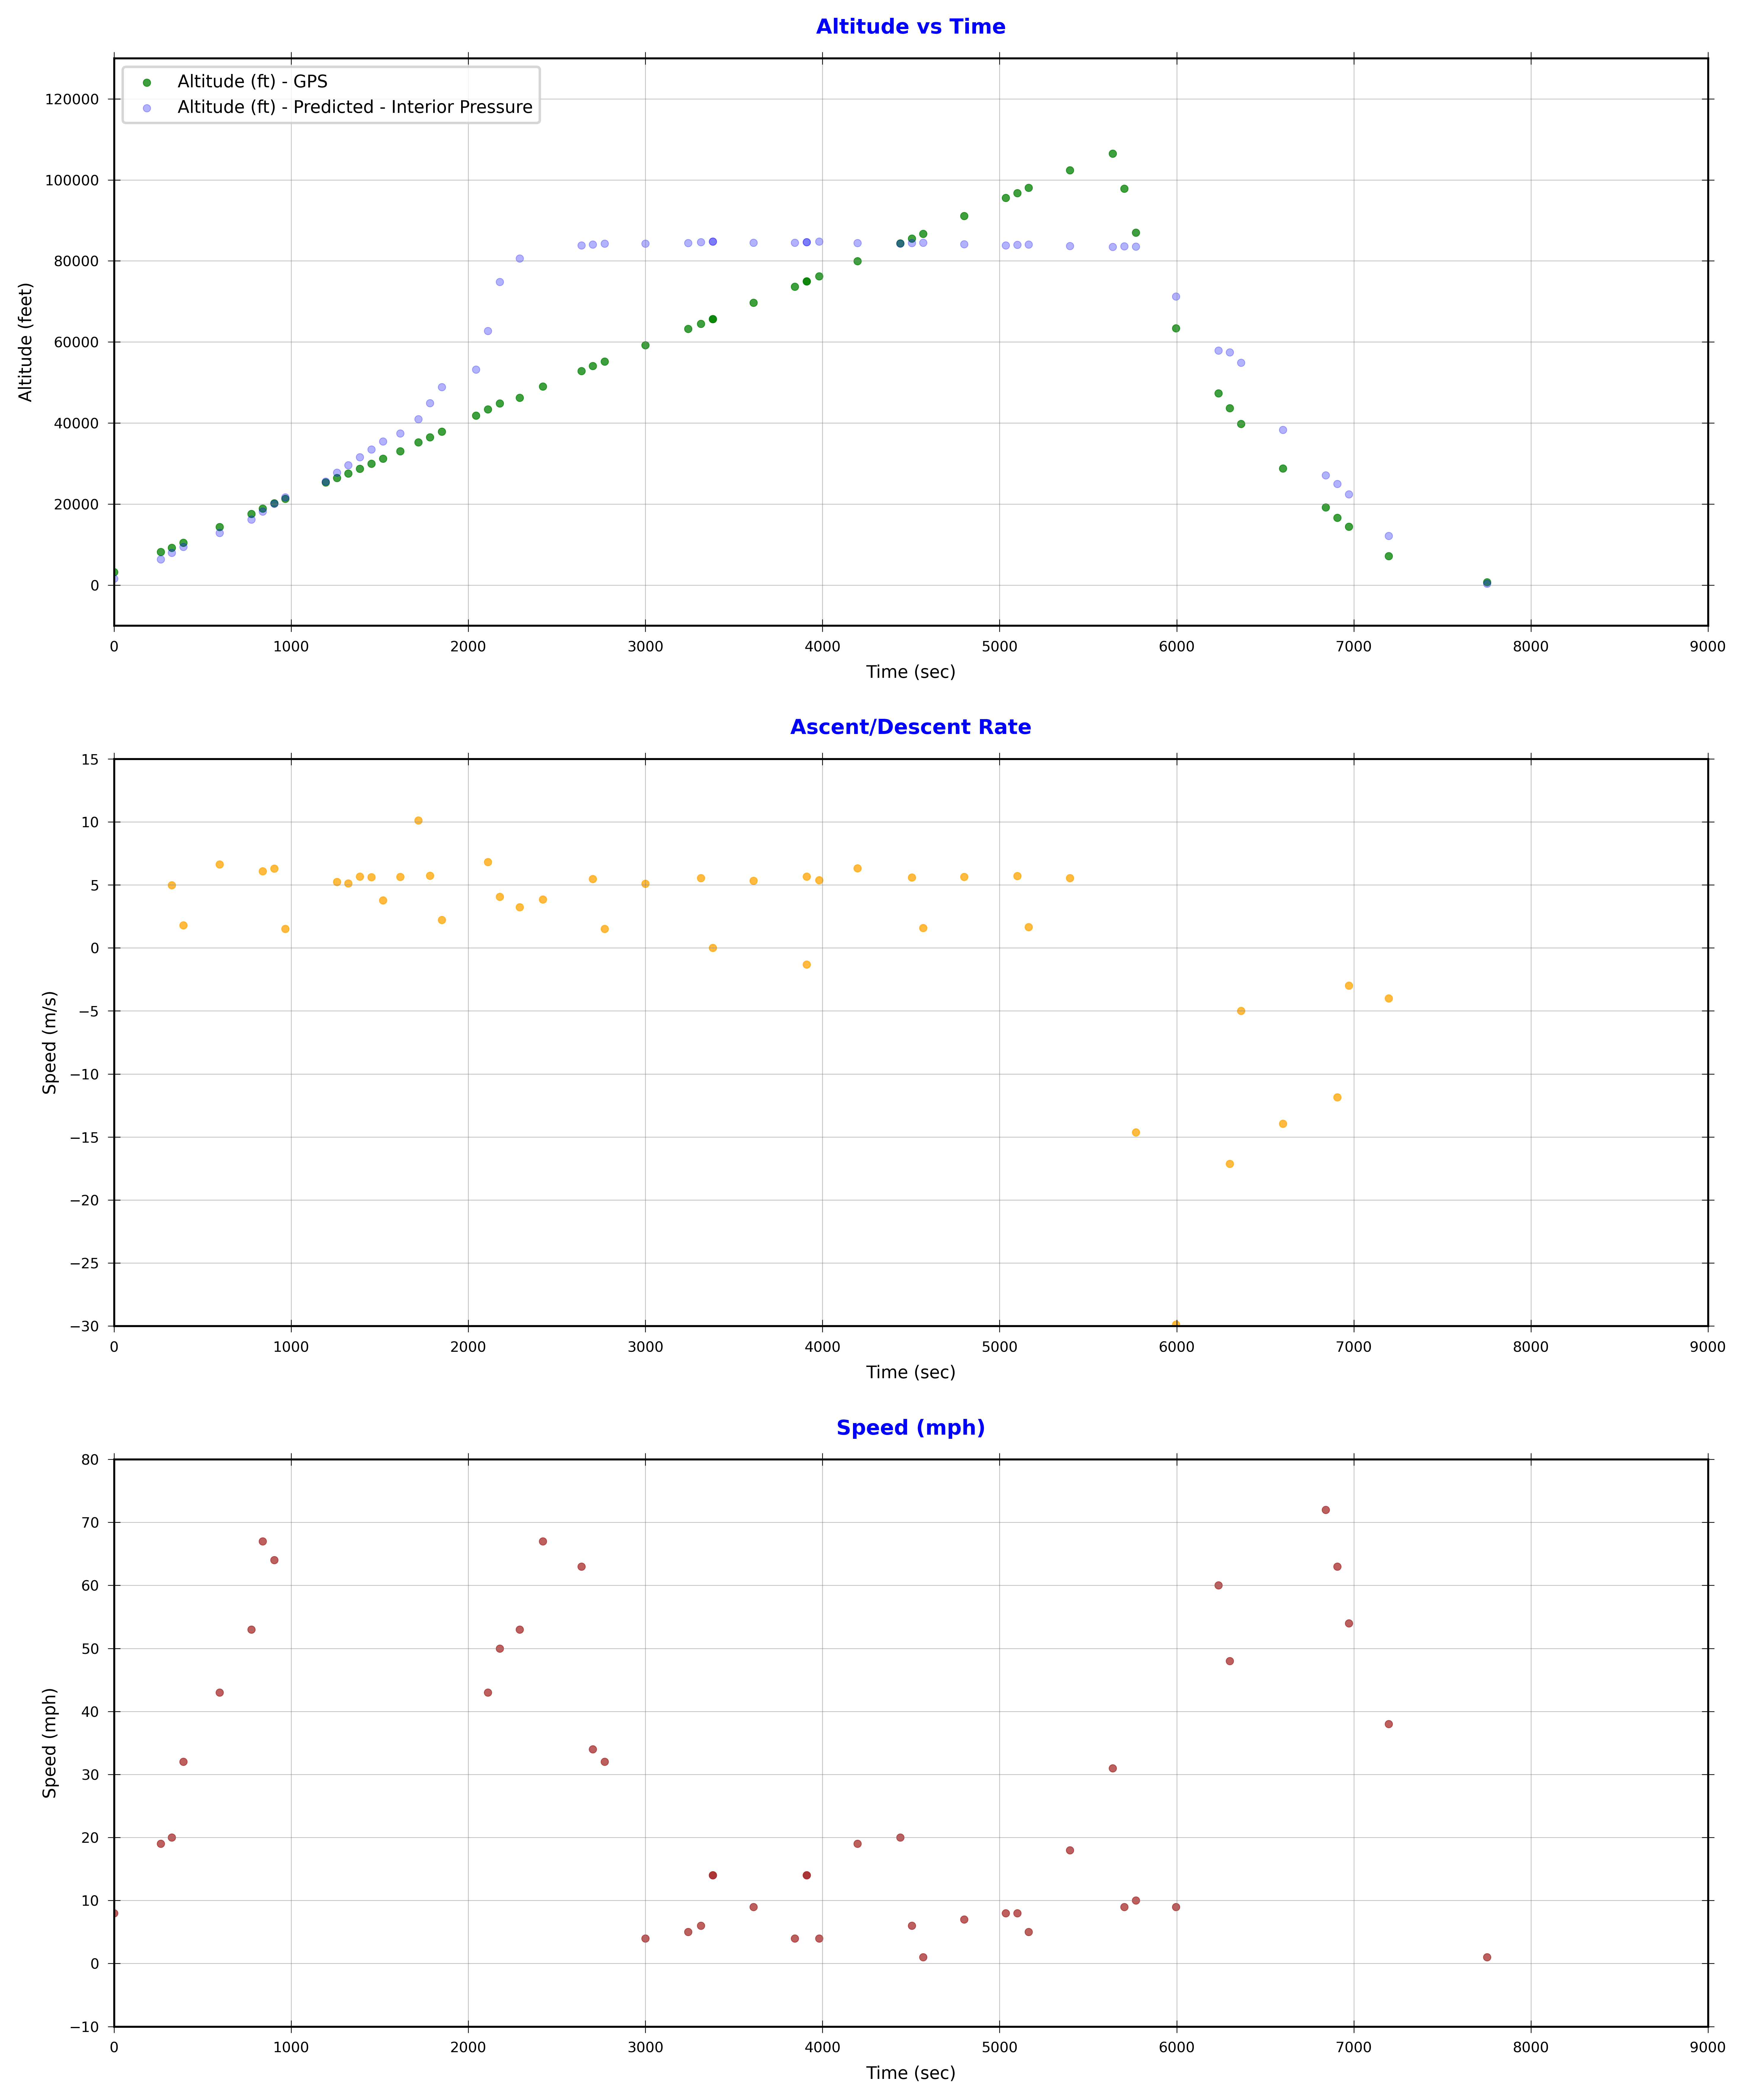

In [50]:
%matplotlib inline

plt.figure(dpi=600, figsize=(10,12))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('GPS Epoch', 'Altitude (ft)', data=df, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.75, linewidth=0.3)
plot1.scatter('GPS Epoch', 'Predict IP Alt(ft)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Time (sec)', size='x-small')
plot1.set_ylabel('Altitude (feet)', size='x-small')
plot1.set_title('Altitude vs Time', color='blue', size='small', pad=10.0, weight='bold')
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.set_ylim([-10000,130000])
plot1.set_xlim([0,9000])
plot1.legend(['Altitude (ft) - GPS', 'Altitude (ft) - Predicted - Interior Pressure'], fontsize='x-small', loc='upper left')

plot2.scatter('GPS Epoch', 'Rate (mps)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.75,linewidth=0.3)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Time (sec)', size='x-small')
plot2.set_ylabel('Speed (m/s)', size='x-small')
plot2.set_title('Ascent/Descent Rate', color='blue', size='small', pad=10.0, weight='bold')
plot2.grid(visible=True, which='both', linewidth=0.3)
plot2.set_ylim([-30,15])
plot2.set_xlim([0,9000])

plot3.scatter('GPS Epoch', 'Speed (mph)', data=df, marker='.', color='brown', cmap=plt.get_cmap("jet"), alpha=0.75, linewidth=0.3)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Time (sec)', size='x-small')
plot3.set_ylabel('Speed (mph)', size='x-small')
plot3.set_title('Speed (mph)', color='blue', size='small', pad=10.0, weight='bold')
plot3.grid(visible=True, which='both', linewidth=0.3)
plot3.set_ylim([-10,80])
plot3.set_xlim([0,9000])

plt.tight_layout(pad=1.5)
plt.show()

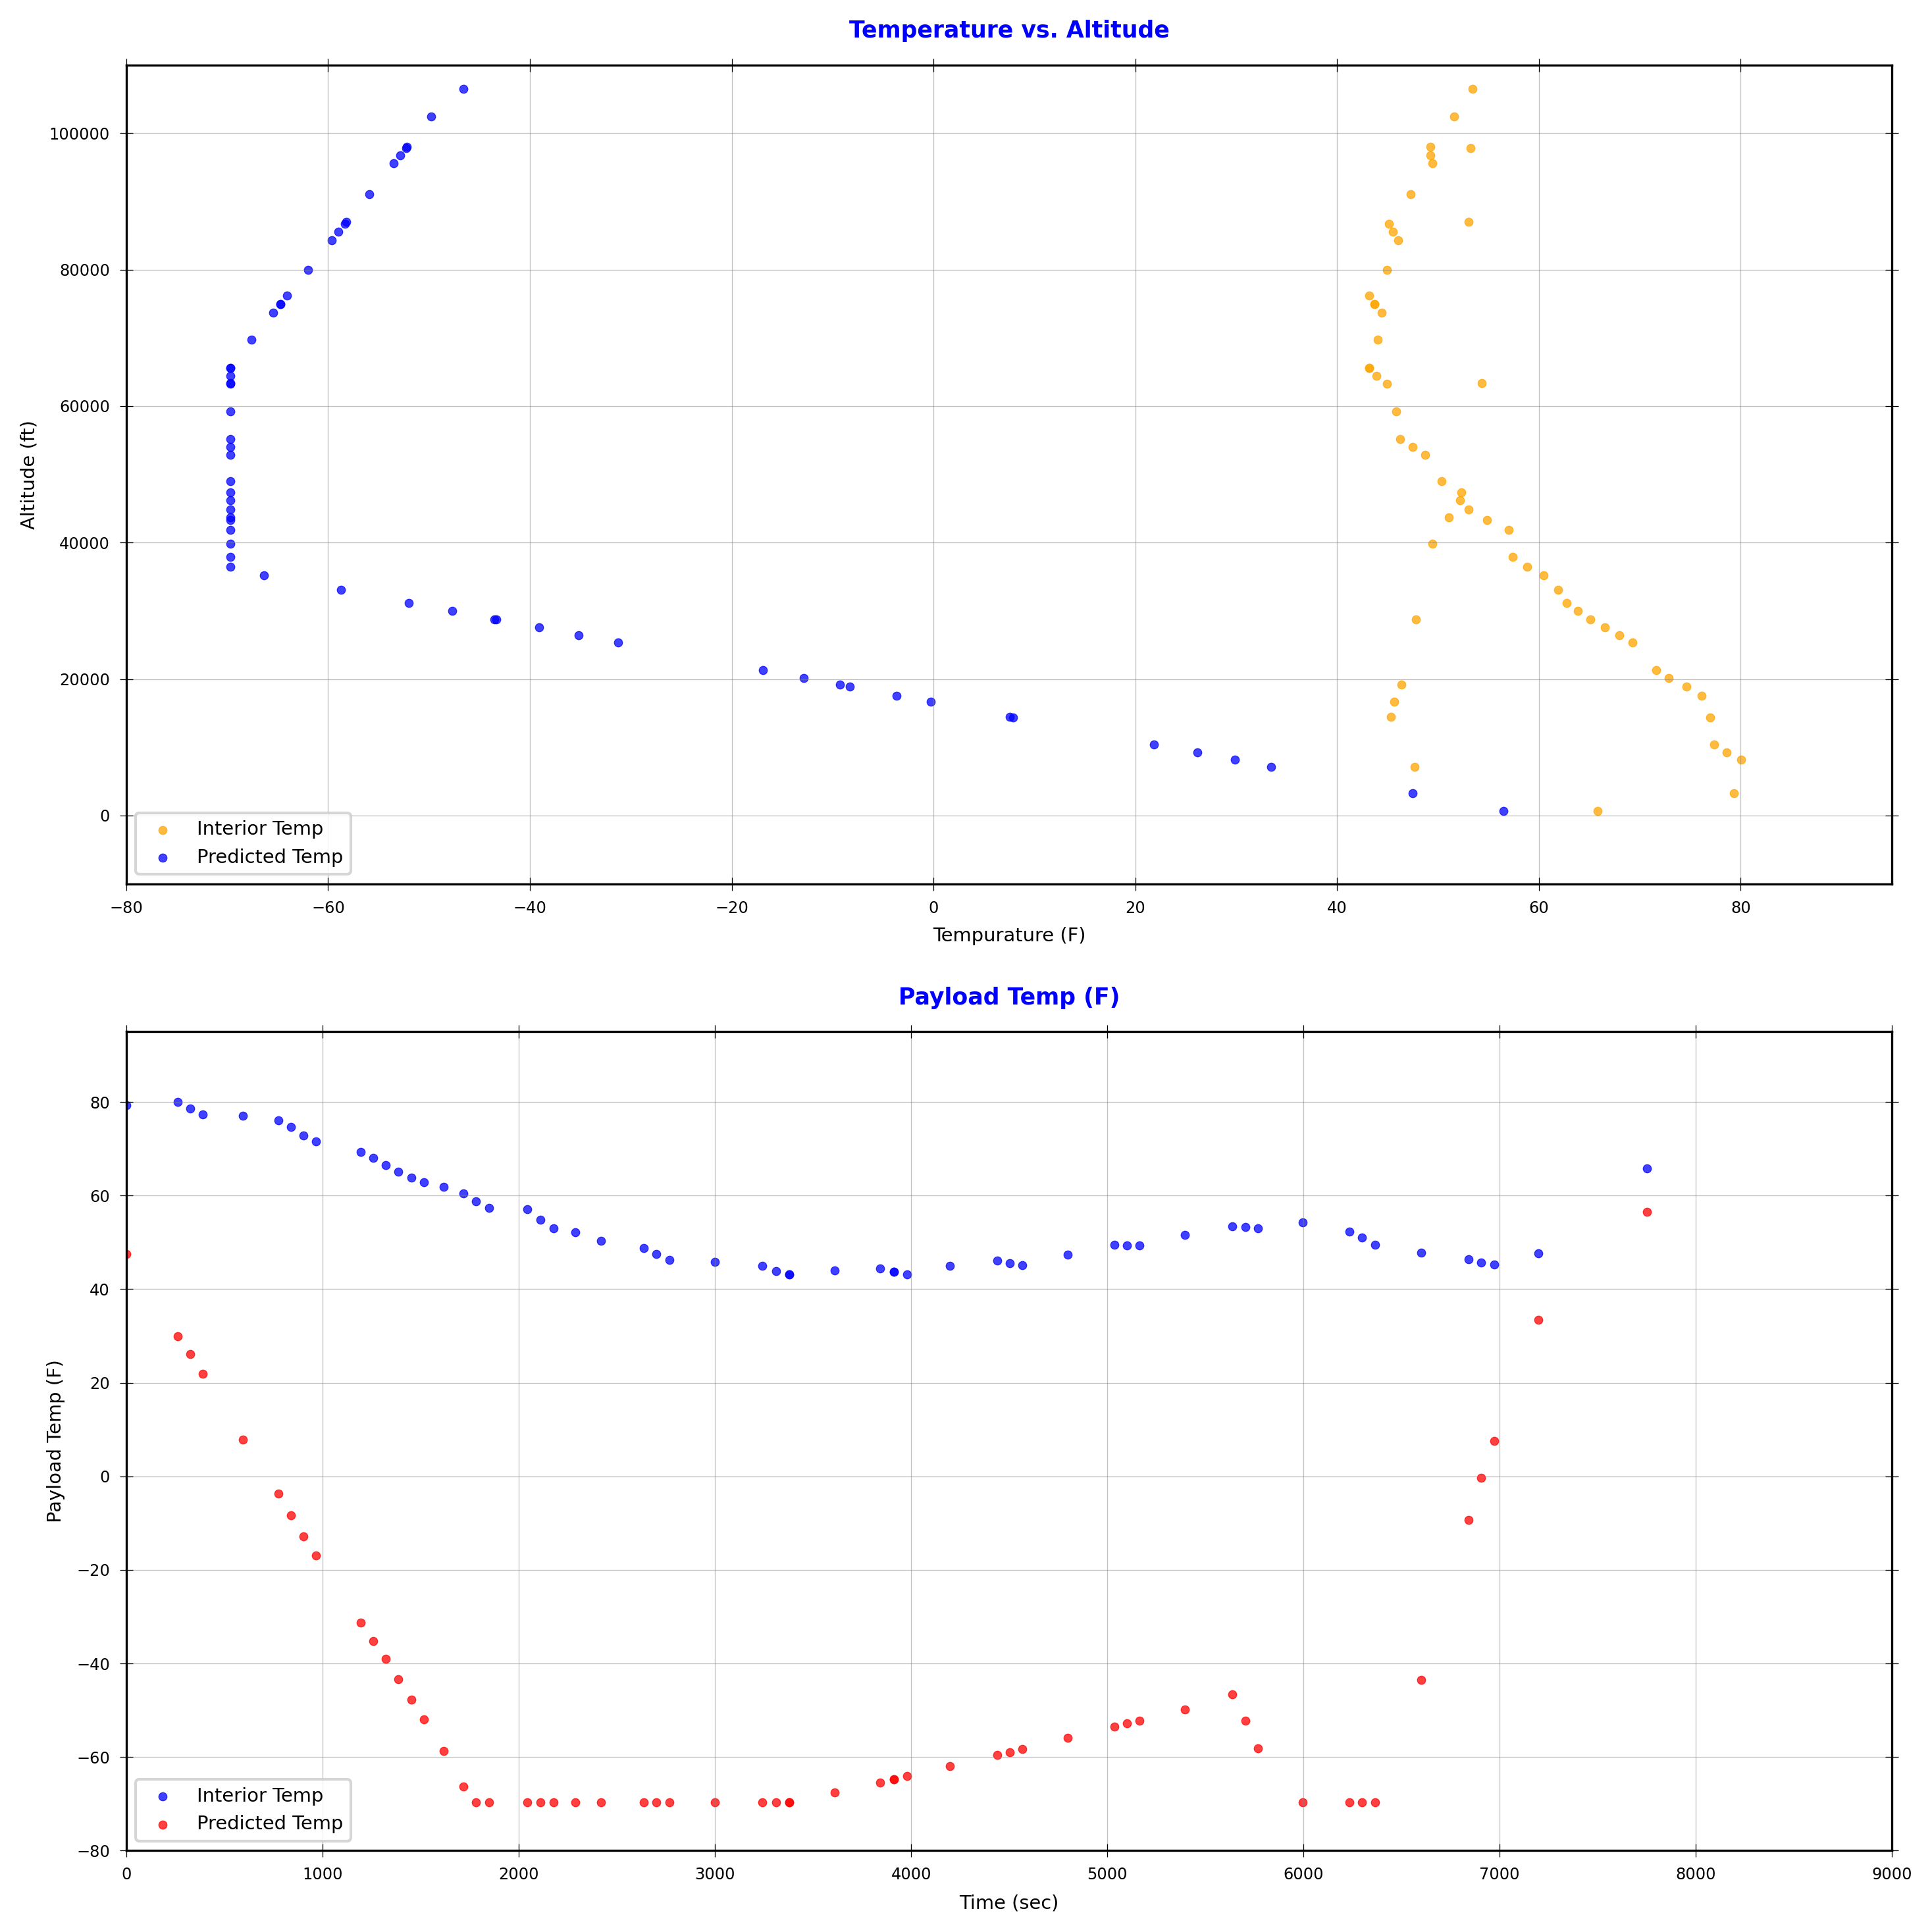

In [51]:
%matplotlib inline

plt.figure(dpi=300, figsize=(10,10))
plot4 = plt.subplot2grid((2,1),(0,0))
plot5 = plt.subplot2grid((2,1),(1,0))

plot4.scatter('Interior Temp (F)', 'Altitude (ft)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.75, linewidth=0.3)
plot4.scatter('Predict Alt Temp(F)', 'Altitude (ft)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.75, linewidth=0.3)
plot4.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot4.set_xlabel('Tempurature (F)', size='x-small')
plot4.set_ylabel('Altitude (ft)', size='x-small')
plot4.set_title('Temperature vs. Altitude', color='blue', size='small', pad=10.0, weight='bold')
plot4.grid(visible=True, which='both', linewidth=0.3)
plot4.set_xlim([-80,95])
plot4.set_ylim([-10000,110000])
plot4.legend(['Interior Temp', 'Predicted Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plot5.scatter('GPS Epoch', 'Interior Temp (F)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.75, linewidth=0.3)
plot5.scatter('GPS Epoch', 'Predict Alt Temp(F)', data=df, marker='.', color='red', cmap=plt.get_cmap("jet"), alpha=0.75, linewidth=0.3)
plot5.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot5.set_xlabel('Time (sec)', size='x-small')
plot5.set_ylabel('Payload Temp (F)', size='x-small')
plot5.set_title('Payload Temp (F)', color='blue', size='small', pad=10.0, weight='bold')
plot5.grid(visible=True, which='both', linewidth=0.3)
plot5.set_ylim([-80,95])
plot5.set_xlim([0,9000])
plot5.legend(['Interior Temp', 'Predicted Temp'], fontsize='x-small', loc='lower left')

plt.tight_layout(pad=1.5)
plt.show()

In [52]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'TxC', 'Interior Temp ©', 'Pressure',
       'Battery', 'Sat', 'Name', 'Num', 'Column15', 'Telemetry', 'GPS Time',
       'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)', 'Voltage',
       'Speed (kph)', 'Altitude (m)', 'Interior Temp (F)', 'I Pressure',
       'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

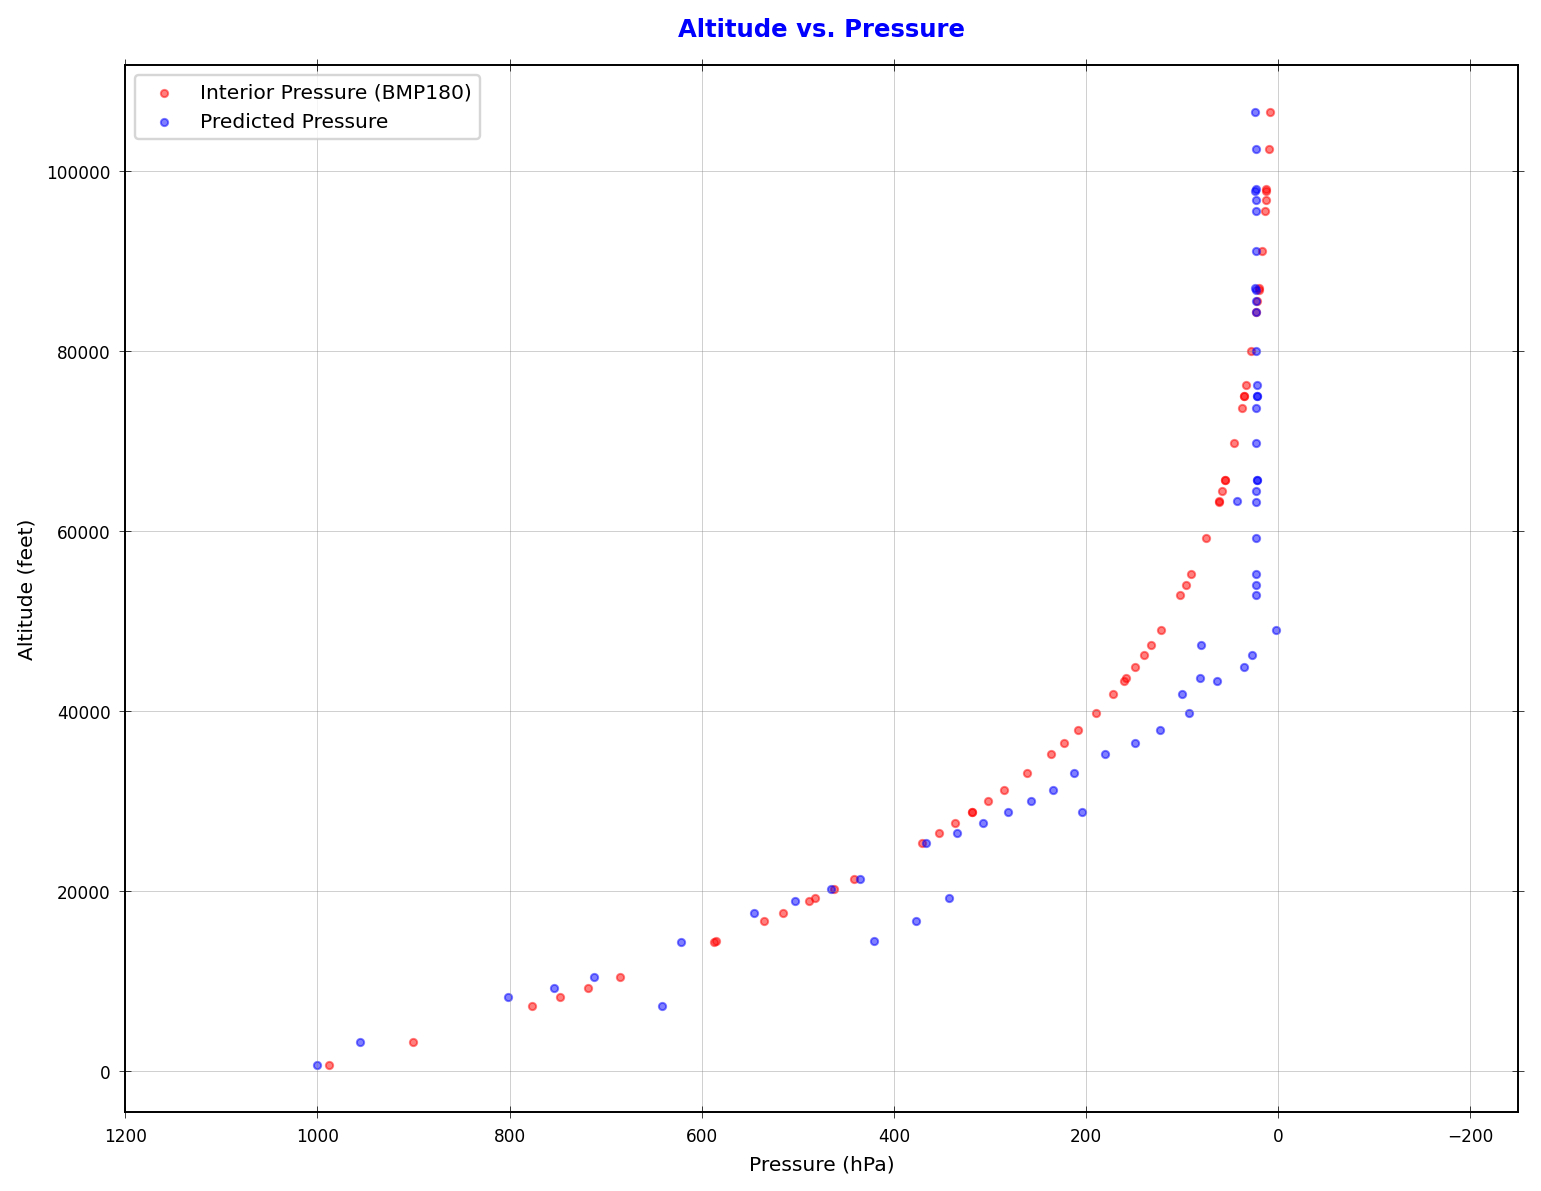

In [65]:
%matplotlib inline

plt.figure(dpi=175, figsize=(10,8))
plot1 = plt.subplot2grid((1,1),(0,0))

plot1.scatter('Predict Alt Pressure', 'Altitude (ft)', marker='.', data=df, color='red', alpha=0.5, linewidth=0.8)
plot1.scatter('I Pressure', 'Altitude (ft)', marker='.', data=df, color='blue', alpha=0.5, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_ylabel('Altitude (feet)', size='small')
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_title('Altitude vs. Pressure', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.legend(['Interior Pressure (BMP180)', 'Predicted Pressure'], fontsize='small', loc='upper left')
plot1.set_xlim([1200,-250])

plt.tight_layout(pad=5.0)
plt.show()

In [54]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'TxC', 'Interior Temp ©', 'Pressure',
       'Battery', 'Sat', 'Name', 'Num', 'Column15', 'Telemetry', 'GPS Time',
       'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)', 'Voltage',
       'Speed (kph)', 'Altitude (m)', 'Interior Temp (F)', 'I Pressure',
       'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

In [118]:
%matplotlib inline

plt.figure(dpi=800, figsize=(10,15))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))

plot1.scatter('GPS Epoch', 'Voltage', marker='.', data=df, color='darkgreen', alpha=0.5, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Time (secs)', size='small')
plot1.set_ylabel('Voltage', size='small')
plot1.set_title('Voltage vs. Time', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.set_xlim([-100,8000])
plot1.grid(visible=True, which='both', linewidth=0.3)

plot2.scatter('GPS Epoch', 'Rate (fps)', marker='.', data=df, color='orange', alpha=0.75, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('GPS Epoch', size='small')
plot2.set_ylabel('Ascent/Descent Rate (fps)', size='small')
plot2.set_title('Ascent/Descent Rate (fps) vs Time', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot2.set_xlim([-100,8000])
plot2.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [119]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'TxC', 'Interior Temp ©', 'Pressure',
       'Battery', 'Sat', 'Name', 'Num', 'Column15', 'Telemetry', 'GPS Time',
       'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)', 'Voltage',
       'Speed (kph)', 'Altitude (m)', 'Interior Temp (F)', 'I Pressure',
       'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

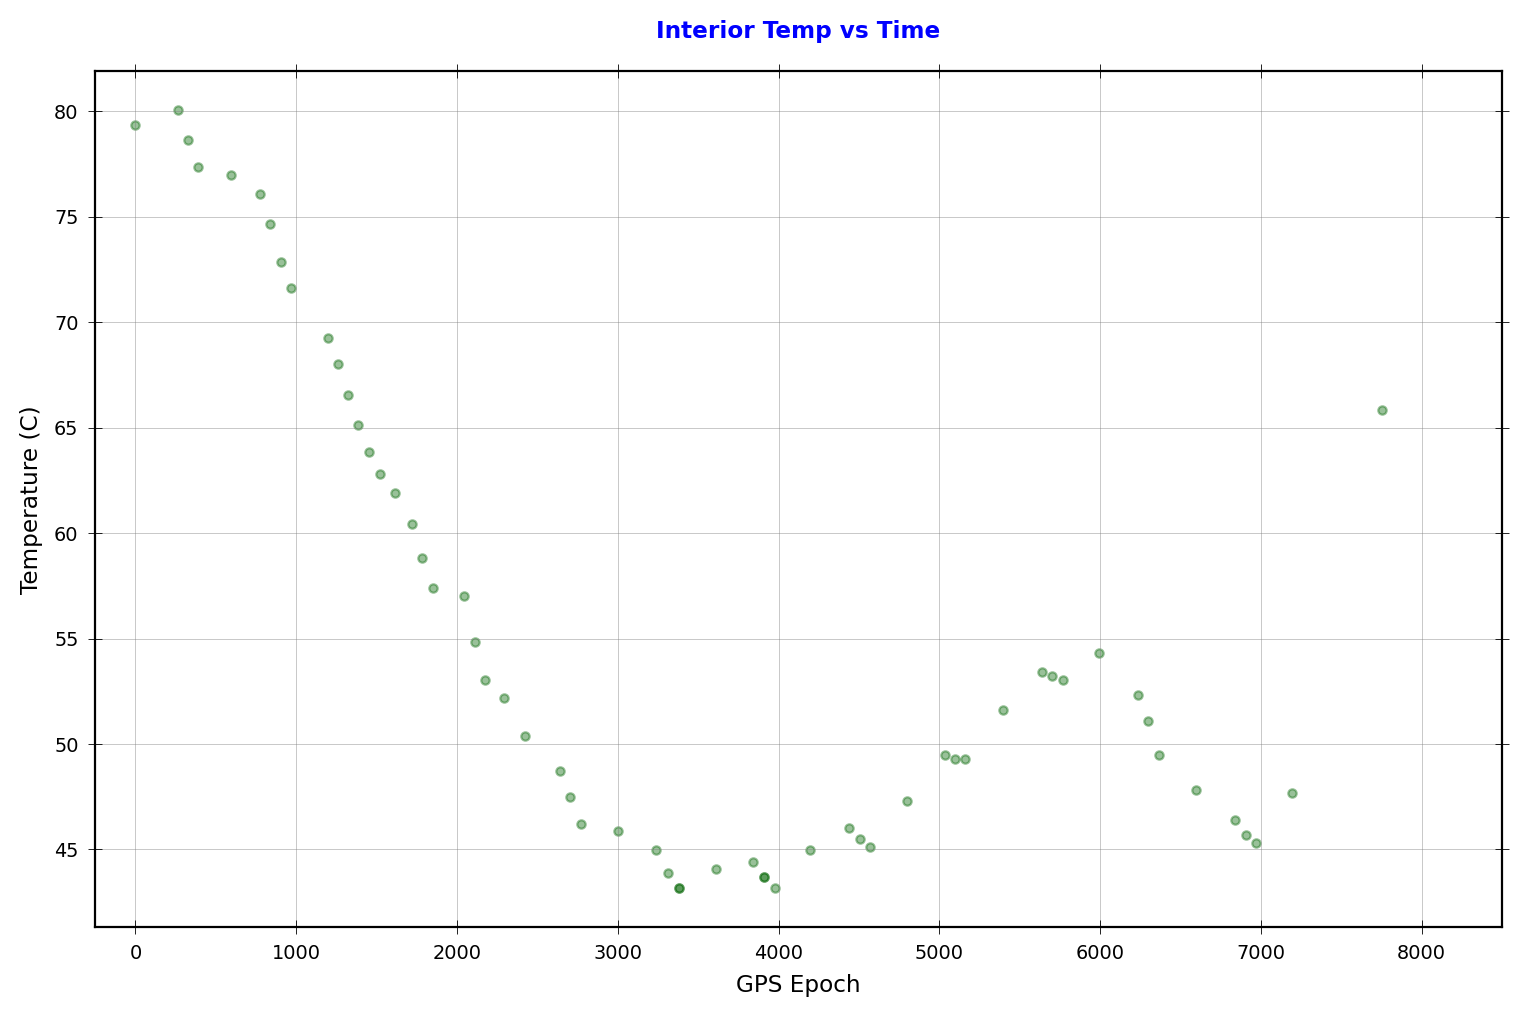

In [137]:
%matplotlib inline

plt.figure(dpi=200, figsize=(8,10))
plot1 = plt.subplot2grid((2,1),(0,0))

plot1.scatter('GPS Epoch', 'Interior Temp (F)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('GPS Epoch', size='small')
plot1.set_ylabel('Temperature (F)', size='small')
plot1.set_xlim([-250,8500])
plot1.set_title('Interior Temp vs Time', color='blue', fontsize='small', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [138]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'TxC', 'Interior Temp ©', 'Pressure',
       'Battery', 'Sat', 'Name', 'Num', 'Column15', 'Telemetry', 'GPS Time',
       'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)', 'Voltage',
       'Speed (kph)', 'Altitude (m)', 'Interior Temp (F)', 'I Pressure',
       'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

In [139]:
df.head(5)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,...,Rate (mps),Cardinal Direction,GPS Epoch,Predict Alt Pressure,Predict Alt Temp(C),Predict Alt Temp(F),Predict IP Alt(m),Predict IP Alt(ft),Predict IP Temp(C),Predict IP Temp(F)
0,2023-04-21,14:26:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10",049TxC,26.30C,956.16hPa,6.19V,05,Atlas,...,NaN,ESE,0,900.552665,8.607657,47.493782,487.887304,1600.680135,11.828976,53.292157
1,2023-04-21,14:30:23,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1",050TxC,26.70C,802.26hPa,6.20V,06,Atlas,...,23.890514,E,263,747.978383,-1.170167,29.893699,1929.434435,6330.165478,2.462482,36.432467
2,2023-04-21,14:31:26,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10",051TxC,25.90C,754.47hPa,6.25V,05,Atlas,...,4.986338,ENE,326,718.502297,-3.242756,26.163038,2424.758771,7955.245325,-0.754922,30.641140
3,2023-04-21,14:32:30,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1",052TxC,25.20C,712.48hPa,6.27V,05,Atlas,...,1.805011,NE,390,685.513125,-5.645670,21.837794,2879.643306,9447.648657,-3.709206,25.323429
4,2023-04-21,14:35:55,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10",053TxC,25.00C,622.88hPa,6.20V,05,Atlas,...,6.629400,NE,595,587.399052,-13.392865,7.892843,3933.000131,12903.543756,-10.548694,13.012352


In [140]:
df['Lat_DD'] = df['Lat'].apply(convert_lat_gps_coord)

In [141]:
df['Lon_DD'] = df['Lon'].apply(convert_lon_gps_coord)

In [142]:
df.tail(5)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,...,GPS Epoch,Predict Alt Pressure,Predict Alt Temp(C),Predict Alt Temp(F),Predict IP Alt(m),Predict IP Alt(ft),Predict IP Temp(C),Predict IP Temp(F),Lat_DD,Lon_DD
54,2023-04-21,16:20:01,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1",101TxC,8.00C,343.46hPa,6.02V,05,Atlas,...,6841,482.428248,-22.942748,-9.296947,8266.931269,27122.477958,-38.665262,-37.597471,41.420000,-87.897222
55,2023-04-21,16:21:07,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1",102TxC,7.60C,377.79hPa,6.07V,06,Atlas,...,6907,535.320392,-17.940885,-0.293594,7610.710207,24969.521714,-34.410459,-29.938826,41.428611,-87.874444
56,2023-04-21,16:22:12,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5",103TxC,7.40C,421.67hPa,6.09V,06,Atlas,...,6972,585.238918,-13.574884,7.565208,6829.369070,22406.066536,-29.343259,-20.817866,41.437500,-87.861111
57,2023-04-21,16:25:57,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5",104TxC,8.70C,641.63hPa,6.01V,05,Atlas,...,7197,777.100037,0.813537,33.464366,3700.771248,12141.637973,-9.041017,15.726169,41.467222,-87.817778
58,2023-04-21,16:35:12,CDT:,"KB9LNS-13>APLIGA,W9AZ-2,WIDE1*,WIDE2-1,qAR,K9MQ-1",004TxC,18.80C,1000.28hPa,6.04V,05,Atlas,...,7752,987.737261,13.605282,56.489508,110.886363,363.800403,14.279251,57.702652,41.466667,-87.805278


In [143]:
# Drop last row since it's invalid
# df2.drop(df2.tail(1).index,inplace=True)

In [144]:
df.tail(5)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,...,GPS Epoch,Predict Alt Pressure,Predict Alt Temp(C),Predict Alt Temp(F),Predict IP Alt(m),Predict IP Alt(ft),Predict IP Temp(C),Predict IP Temp(F),Lat_DD,Lon_DD
54,2023-04-21,16:20:01,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1",101TxC,8.00C,343.46hPa,6.02V,05,Atlas,...,6841,482.428248,-22.942748,-9.296947,8266.931269,27122.477958,-38.665262,-37.597471,41.420000,-87.897222
55,2023-04-21,16:21:07,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1",102TxC,7.60C,377.79hPa,6.07V,06,Atlas,...,6907,535.320392,-17.940885,-0.293594,7610.710207,24969.521714,-34.410459,-29.938826,41.428611,-87.874444
56,2023-04-21,16:22:12,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5",103TxC,7.40C,421.67hPa,6.09V,06,Atlas,...,6972,585.238918,-13.574884,7.565208,6829.369070,22406.066536,-29.343259,-20.817866,41.437500,-87.861111
57,2023-04-21,16:25:57,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5",104TxC,8.70C,641.63hPa,6.01V,05,Atlas,...,7197,777.100037,0.813537,33.464366,3700.771248,12141.637973,-9.041017,15.726169,41.467222,-87.817778
58,2023-04-21,16:35:12,CDT:,"KB9LNS-13>APLIGA,W9AZ-2,WIDE1*,WIDE2-1,qAR,K9MQ-1",004TxC,18.80C,1000.28hPa,6.04V,05,Atlas,...,7752,987.737261,13.605282,56.489508,110.886363,363.800403,14.279251,57.702652,41.466667,-87.805278


In [145]:
mid = int(len(df['Lon_DD'])/2)

In [146]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

In [149]:
fig = go.Figure(go.Scattermapbox(
    name = 'Flight Path',
    mode = "markers+lines",
    lon = df['Lon_DD'],
    lat = df['Lat_DD'],
    hoverinfo = 'lon+lat',
    hovertemplate =
    "Longitude: %{lon}<br>" +
    "Latitude: %{lat}<br>" + 
    "%{text}",
    text = 'Altitude: ' + df['Altitude (ft)'].astype(str) + ' (ft)<br>Speed:' + df['Speed (mph)'].astype(str) +  '<br>Int Temp: ' + df['Interior Temp (F)'].astype(str) + '<br>Int Pressure: ' + df['I Pressure'].astype(str),
    marker = dict(
        size = 7,
        opacity = 1.0,
        symbol = 'circle',    
        reversescale = False,
        autocolorscale = False,
        colorscale = scl,
        cmin = 0,
        color = df['Altitude (ft)'], 
        cmax = df['Altitude (ft)'].max(),
        colorbar_title="<b>High Altitude Balloon</b><br>April 21st 2023")))

In [153]:
fig.update_layout(
    height = 750,
    width = 1500,
    margin ={'l':10,'t':50,'b':10,'r':10},
    mapbox = {
        'center': {'lon': df['Lon_DD'].iloc[mid], 'lat': df['Lat_DD'].iloc[mid]},
        'style': "stamen-terrain",
        'zoom': 7.5,
        })

fig.update_layout(
        title = '<b>High Altitude Balloon - Flight Path & Altitude</b>',
        geo_scope='usa',
        geo = dict(
            scope = 'north america',
            showland = True,
            landcolor = "rgb(212, 212, 212)",
            subunitcolor = "rgb(255, 255, 255)",
            countrycolor = "rgb(255, 255, 255)",
            showlakes = True,
            lakecolor = "rgb(255, 255, 255)",
            showsubunits = True,
            showcountries = True,
            resolution = 50,
            projection = dict(
                type = 'conic conformal',
                rotation_lon = -100
            ),
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ -140.0, -55.0 ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ 20.0, 60.0 ],
                dtick = 5
            )
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        ),
    )

fig.show()